# **Introduction**
This notebook documents the analysis of the PTB-XL
electrocardiography dataset.

# **Tools**


The NeuroKit2 package has tools dedicated to biosignal processing and it is very useful for our purposes. Additionally, we will be using ecg_plot, which is a visualization toolkit that plots standard ECG chart from data.

In [ ]:
#Installation of requirements
!pip install wfdb
!pip install ecg_plot
!pip install neurokit2

In [3]:
# Libraries:
from pathlib import Path
import os
import zipfile
from google.colab import drive
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter
import ecg_plot
import neurokit2 as nk
from copy import deepcopy
#Classifiers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# **Data download and setup**

In [ ]:
#Data downloaded to Drive folder from physionet.org and unzip it
drive.mount('/content/drive/')
zip_folder = Path("/content/drive/MyDrive/PTB-XL")
if not zip_folder.exists():
    zip_folder.mkdir(parents=True, exist_ok=True)
    os.chdir(zip_folder)
    !wget -r -N -c https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip
else:
    print("Data located in Drive.")

os.chdir("/content")
data_folder = Path('/content/')
data_folder.mkdir(parents=True, exist_ok=True)

if not (data_folder / 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2').exists():  
  with zipfile.ZipFile(zip_folder / 'physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip', 'r') as zip_ref:
      zip_ref.extractall(data_folder)
      print('Folder unzipped.')
data_folder = data_folder / 'ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2'

In [7]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [8]:
# We select the sampling rate we want to use in our study
sampling_rate=100
# Load and convert annotation data
Y = pd.read_csv(str(data_folder)+'/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
# Load raw signal data
ecg_raw = load_raw_data(Y, sampling_rate, str(data_folder) + '/')
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(data_folder /'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# **Data exploration**

Determine data shape and plot initial rows for visualization.

In [ ]:
print(Y.shape)
Y.head(5)

(21801, 44)


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,QRS-CLBB,ST-ELEV-MI,ST-DEPR-MI,Q-ISC,Q-ISC-QPeak,Q-ISC-V2V3,Q-ISC-RPeak,STRAIN,MI-ALL,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,False,False,False,False,False,False,False,False,False,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,False,False,False,False,False,False,False,False,False,[NORM]


In [9]:
n_patients = len(dict(Counter(Y['patient_id'])))
n_recordings = len(Y)
print('There are in total ', n_recordings,'signals from ', n_patients, 'patients.')

There are in total  21801 signals from  18869 patients.


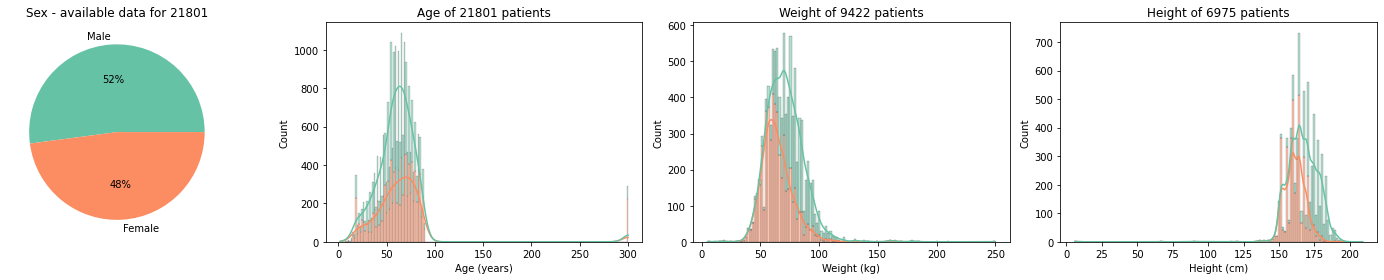

In [ ]:
sex_values = Y.groupby('sex').size()
palette_color =  sns.color_palette('Set2',2)
# Plot patients' characteristics distributions (age, sex, height, weight)
plt.figure(figsize = (20, 4))
plt.subplot(141) 
plt.pie(sex_values, labels = ['Male','Female'], colors=palette_color, autopct='%1.0f%%')
plt.title('Sex - available data for '+str(len(Y[~pd.isna(Y.sex)])))
plt.subplot(142) 
sns.histplot(data=Y, x="age", hue="sex", multiple="stack", palette=palette_color, kde=True, legend=False)
plt.xlabel('Age (years)')
plt.title('Age of '+str(len(Y[~pd.isna(Y.age)]))+' patients')
plt.subplot(143)
sns.histplot(data=Y, x="weight", hue="sex", multiple="stack", palette=palette_color, kde=True, legend=False)
plt.xlabel('Weight (kg)')
plt.title('Weight of '+str(len(Y[~pd.isna(Y.weight)]))+' patients')
plt.subplot(144)
sns.histplot(data=Y, x="height", hue="sex", multiple="stack", palette=palette_color, kde=True, legend=False)
plt.xlabel('Height (cm)')
plt.title('Height of '+str(len(Y[~pd.isna(Y.height)]))+' patients')
plt.tight_layout()
plt.show()

There is almost an equal distribution between males and females in the data.

It should be noted that age values of 300 are reported because ages over 89 years appear as 300 in compliance with HIPAA standards.

# **Label distribution**

We first take a look at the label distribution throughout the whole dataset.

In [ ]:
Y.diagnostic_superclass.apply(tuple).value_counts()

(NORM,)                9072
(MI,)                  2532
(STTC,)                2401
(CD,)                  1708
(MI, CD)               1300
(HYP, STTC)             781
(STTC, MI)              600
(HYP,)                  535
(STTC, CD)              471
(NORM, CD)              407
()                      405
(HYP, STTC, MI)         361
(HYP, CD)               300
(STTC, MI, CD)          223
(HYP, STTC, CD)         211
(HYP, MI)               183
(HYP, STTC, MI, CD)     156
(HYP, MI, CD)           117
(STTC, NORM)             28
(STTC, NORM, CD)          5
(HYP, NORM, CD)           2
(HYP, NORM)               2
(HYP, NORM, MI, CD)       1
Name: diagnostic_superclass, dtype: int64

Some recordings have no label assigned, which could be a problem when classifying.

We create a graphical summary of the dataset in terms of diagnostic superclasses.

NORM: Normal ECG
CD: Conduction Disturbance
MI: Myocardial Infarction
HYP: Hypertrophy
STTC: ST/T change


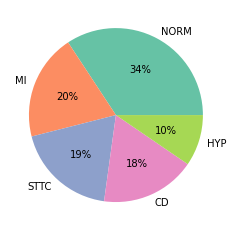

In [ ]:
labels=Y['diagnostic_superclass']
labels_per = (labels.explode(['diagnostic_superclass'])).value_counts(normalize=True).mul(100)
print('NORM: Normal ECG\nCD: Conduction Disturbance\nMI: Myocardial Infarction\nHYP: Hypertrophy\nSTTC: ST/T change')

plt.figure()
plt.pie(labels_per, labels = labels_per.index, colors=sns.color_palette('Set2',5), autopct='%1.0f%%')
plt.show()

There is a large proportion of healthy control samples and good diversity of pathologies.

#**Signal visualization**

We select a random patient and plot the whole signal as a first step of visualization.

Recording:  records100/11000/11141_lr


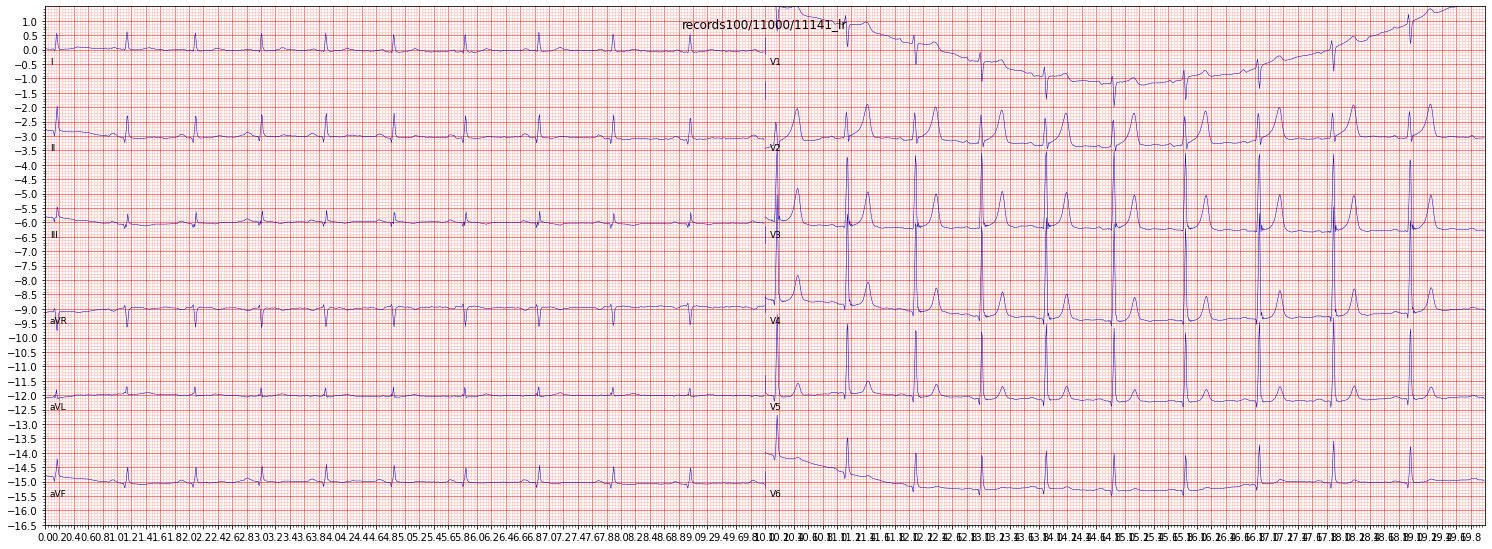

In [22]:
# Patient chosen and its information
patient = np.random.choice(Y['filename_lr'])
information = Y.loc[int(patient.split('/')[-1].split('_')[0])]
print('Recording: ', patient)

x = wfdb.rdsamp(os.path.join(data_folder, patient))
ecg_pat = np.array(x[0])

ecg_plot.plot(ecg_pat.transpose(), sample_rate = sampling_rate, title = patient, columns=2)
ecg_plot.show()

For the detection of peaks we are going to use NeuroKit2 package.

We use the signal from lead I to apply the different routines of wave detection. The signal from this lead is very recognizable and commonly used for measurements of the QT interval.

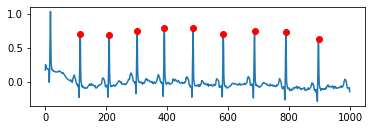

In [23]:
#Select lead II
ecg_signal = ecg_pat[:, 1]

signals, ecg_info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)

# Extract R-peaks locations
_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=sampling_rate)
# Visualize R-peaks in ECG signal
plt.figure()
plt.subplot(211)
plt.plot(ecg_signal)
for p in rpeaks['ECG_R_Peaks']:
    plt.plot(p, ecg_signal[p], "o", color='r')
plt.show()

The rest of the ECG waves are detected and different parameters calculated with them:

* Heart rate, calculated through the R peaks.

* QRS duration, time between the Q and S peak. This time interval has been studied as a marker for different conduction disorders.

* QT interval is the body surface representation of the duration of ventricular depolarization and subsequent repolarization. There is a cause–effect relationship between prolongation of this interval and cardiac arrhythmias, so it is important for clinicians.

* The QT interval is heart rate dependent. As the heart rate increase the interval will shorten. To account for this, and thereby improve the reliability of QT measurement, the QT interval can be corrected for heart rate (QTc). Sagie's formula has been used for this.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


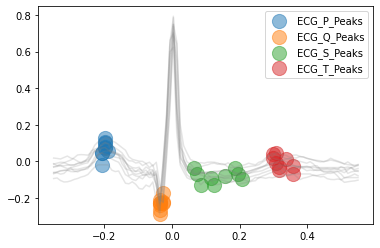

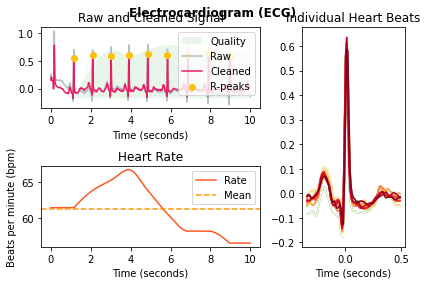

In [24]:
# Delineate the ECG signal and visualizing all peaks of ECG complexes
_, waves_peak = nk.ecg_delineate(ecg_signal, 
                                 rpeaks, 
                                 sampling_rate=sampling_rate, 
                                 method="peak", 
                                 show=True, 
                                 show_type='peaks')

#Heart rate
ecg_rate = np.nanmean(nk.signal_rate(rpeaks, sampling_rate=sampling_rate))
#RR interval
RR_interval = np.nanmean([y - x for x, y in zip(rpeaks['ECG_R_Peaks'], rpeaks['ECG_R_Peaks'][1:])])/sampling_rate
#QRSd
QRSd = np.nanmean([x1 - x2 for (x1, x2) in zip(waves_peak['ECG_S_Peaks'], waves_peak['ECG_Q_Peaks'])])/sampling_rate
#QT interval
QT_interval = np.nanmean([x1 - x2 for (x1, x2) in zip(waves_peak['ECG_T_Peaks'], waves_peak['ECG_Q_Peaks'])])/sampling_rate
#QT interval corrected for heart rate with Sagie's formula (QT and QTc_S are in milliseconds and RR is measured in seconds)
QTc_S = 1000*((QT_interval) + 0.154*(1-RR_interval))

fig = nk.ecg_plot(signals, sampling_rate=sampling_rate, show_type="default")
plt.tight_layout()
plt.show()


**ECG shortening**

We select three beats for a better visualization and plot them with all the relevant information for clinicians.

In [30]:
rpeaks['ECG_R_Peaks'][0]

115

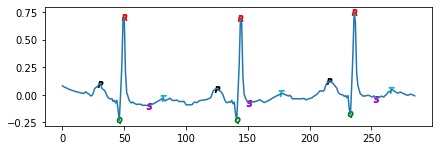

In [32]:
# Focus in 3 R-peaks and calculate parameters
n_beats = 2
if rpeaks['ECG_R_Peaks'][0] > 50:
  ini_point = rpeaks['ECG_R_Peaks'][0] - 50
else:
  ini_point =0

cut_ecg = ecg_pat[ini_point:(rpeaks['ECG_R_Peaks'][n_beats]+50),:]
cut_signal = cut_ecg[:, 1]

plt.subplot(212)
plt.plot(cut_signal)
for i in range(n_beats+1):
    plt.scatter(rpeaks['ECG_R_Peaks'][i]-ini_point, cut_signal[rpeaks['ECG_R_Peaks'][i]-ini_point], c='r', marker="$R$")
    plt.scatter(waves_peak['ECG_P_Peaks'][i]-ini_point, cut_signal[waves_peak['ECG_P_Peaks'][i]-ini_point], c='k', marker="$P$")
    plt.scatter(waves_peak['ECG_Q_Peaks'][i]-ini_point, cut_signal[waves_peak['ECG_Q_Peaks'][i]-ini_point], c='g', marker="$Q$")
    plt.scatter(waves_peak['ECG_S_Peaks'][i]-ini_point, cut_signal[waves_peak['ECG_S_Peaks'][i]-ini_point], c='m', marker="$S$")
    plt.scatter(waves_peak['ECG_T_Peaks'][i]-ini_point, cut_signal[waves_peak['ECG_T_Peaks'][i]-ini_point], c='c', marker="$T$")


plt.tight_layout()
plt.show()

Participant ID:	 6496.0
Record date:	 1993-10-01 18:28:50
Report:	 sinus rhythm. r-s transition zone in v leads displaced to the right. q waves in ii, iii, avf are probably normal. no definite pathology.
Age:	 65.0
Sex:	 Female
Heart rate:  61.567820882003375 bpm
QRS duration:  165 ms
QT interval:  351 ms
QT interval corrected:  354 ms


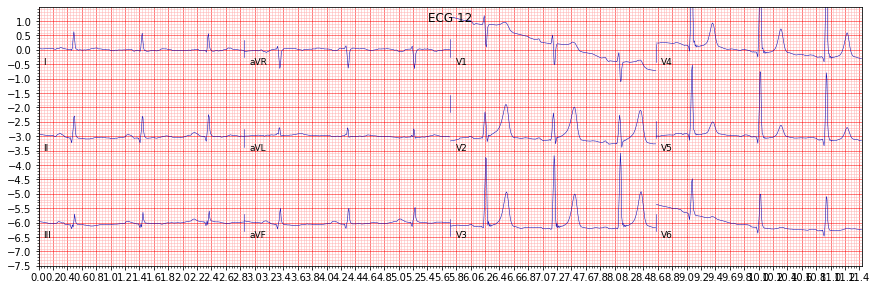

In [33]:
# Report patient information, possible lead problem and plot ECG
print('Participant ID:\t',information.patient_id)
print('Record date:\t',information.recording_date)
print('Report:\t',information.report)
print('Age:\t',information.age)
print('Sex:\t','Male' if information.sex else 'Female')
print('Heart rate: ', ecg_rate, 'bpm')
print('QRS duration: ', int(QRSd*1000), 'ms')
print('QT interval: ', int(QT_interval*1000), 'ms')
print('QT interval corrected: ', int(QTc_S), 'ms')
#Presence of extra beats or pacing
if not pd.isna(information.extra_beats):
    print('Presence of extra beats:', information.extra_beats)
if not pd.isna(information.pacemaker):
    print('Paced rythm.')
#Technical information
if not pd.isna(information.baseline_drift):
    print('Baseline Drift in lead(s):', information.baseline_drift)
if not pd.isna(information.static_noise):
    print('Static Noise in lead(s):', information.baseline_drift)
if not pd.isna(information.burst_noise):
    print('Burst Noise in lead(s):', information.baseline_drift)
if not pd.isna(information.electrodes_problems):
    print('Electrode problem in lead(s):', information.baseline_drift)

ecg_plot.plot(cut_ecg.transpose(), sample_rate = sampling_rate, columns=4)
ecg_plot.show()

#**Supervised classification**

We will train a model on the detection of a normal rythm.

We will use a number of different standard classifiers from the sklearn library will be used. The goal is not to find the optimal performance, but instead to explore a bit.

We start by converting the superclasses into different columns.

In [ ]:
Y = pd.concat([Y, pd.get_dummies(Y['diagnostic_superclass'].apply(pd.Series).stack()).groupby(level=0).sum()], axis=1)

For our classification we remove the unlabeled rows.

In [ ]:
ecg_raw = ecg_raw[Y['diagnostic_superclass'].map(lambda d: len(d)) > 0]
Y = Y[Y['diagnostic_superclass'].map(lambda d: len(d)) > 0]
ecg_raw.shape

(21396, 1000, 12)

We reshape the data and split it into train and test.

In [ ]:
# Split data into train and test
test_fold = 10
nsamples, nx, ny = ecg_raw.shape
ecg=ecg_raw.reshape((nsamples,nx*ny))
# Train
X_train = ecg[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].NORM
# Test
X_test = ecg[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].NORM

In [ ]:
#List of classifiers
classifiers = dict(
    KNN = KNeighborsClassifier(),
    RandomForest = RandomForestClassifier(max_depth=5, n_estimators=100),
    NN = MLPClassifier(),
    AdaBoost = AdaBoostClassifier(),
)

In [ ]:
results = list()
clfs = dict()
scaler = StandardScaler()
# We create a pipe using the make_pipeline method and fit the 
# data into the models
for clf_name, clf in classifiers.items():
        pipe = deepcopy(make_pipeline(scaler, clf))
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results.append(dict(clf_name=clf_name.split("_")[0], 
                           acc=acc, recall=recall, f1=f1))
        clfs[(clf_name)] = pipe
print("Finished training classifiers")

Finished training classifiers


#**Results**
Results for each classifier sorted by f1 score with accuracy and recall displayed. A confusion matrix of the classifier with best performance is shown.

In [ ]:
r_df = pd.DataFrame(results)
r_df[["acc", "recall", "f1"]] *= 100
r_df.sort_values("f1", ascending=False).reset_index(drop=True)

,clf_name,acc,recall,f1
0,NN,70.680871,71.443406,68.491787
1,RandomForest,73.228346,58.359294,66.039953
2,AdaBoost,66.882816,61.786085,62.467192
3,KNN,57.897175,22.429907,32.214765


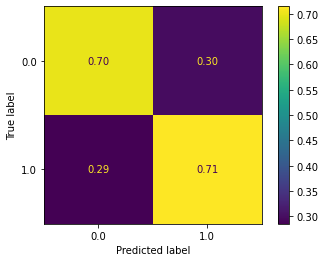

In [ ]:
ConfusionMatrixDisplay.from_estimator(clfs['NN'], X_test, y_test,  colorbar=True, normalize="true", values_format=".2f");
plt.show()

The results show that the highest f1 score achieved with the chosen methods is 68%. However, these classifiers were chosen to give an overview of results from various standard techniques. All of them have hyperparameters which could be tuned, but this was not the purpose.

# **Conclusion**

I was surprised the amount of data available and the number of python packages tailored for electrocardiogram analysis. This dataset covers a broad range of pathologies while also containing a large group of healthy records. After studying the data I still feel like I have only scratched its surface. The amount of metadata makes it increadibly useful for research and further work.